In [1]:
%config InlineBackend.figure_formats = ['svg']
from matplotlib import pyplot as plt
import math
import numpy as np
import ROOT
# ROOT.enableJSVis()  # Enable JavaScript visualization for ROOT objects

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit

print("iminuit version:", iminuit.__version__)

Welcome to JupyROOT 6.24/04
iminuit version: 2.30.1


# $\chi^2$ Fit of Linear Function

In [ ]:
ROOT.gInterpreter.ProcessLine("double fModel(const double var, const double a, const double b) { return a + var * b; }")

ROOT.gInterpreter.ProcessLine("""TFormula model = TFormula("model", "fModel(x, [0..1])");""")
# ROOT.gInterpreter.ProcessLine("""TFormula model = TFormula("model", "[0] + x[0] * [1]");""")

ROOT.gInterpreter.ProcessLine(
"""
std::vector<double>
modelVec(
  const std::vector<double>& varValues,  // variable values
  const std::vector<double>& parValues   // parameter values
) {
  auto funcVals = std::vector<double>(varValues.size());
  for (size_t i = 0; i < varValues.size(); ++i) {
    funcVals[i] = model.EvalPar(&(varValues[i]), &(parValues[0]));
  }
  return funcVals;
}
"""
)

# ROOT.gInterpreter.ProcessLine(
# """
# std::vector<double>
# modelVec(
#   const size_t  n,
#   const double* varValues,
#   const double* parValues
# ) {
#   auto funcVals = std::vector<double>(n);
#   for (size_t i = 0; i < n; ++i) {
#     funcVals[i] = model.EvalPar(&(varValues[i]), parValues);
#   }
#   return funcVals;
# }
# """
# )

# model = ROOT.TFormula("model", "fModel(x, [0..1])")

# model = ROOT.TFormula("model", "[0] + x[0] * [1]")

# our line model, unicode parValuesValuesameter names are supported :)
def line(x, α, β):
  parValues = np.array([α, β], np.double)
  varValues = np.array(x, np.double)
  # varValues = ROOT.std.vector["double"](np.array(x, np.double))
  # print(f"{varValues.shape[0]=}, {varValues=}, {parValues=}")
  # print(f"{type(varValues)}, {type(x)}, {np.array_equal(varValues, x)=}, {x.shape == varValues.shape=}, {x.dtype == varValues.dtype=}")
  # print(f"{repr(x)=}")
  # print(f"{repr(varValues)=}")
  return np.array(ROOT.modelVec(
    varValues,
    parValues,
  ))
  # return np.array(ROOT.modelVec(varValues.shape[0], varValues, parValues))
  # return np.array([model.EvalPar(np.array([element, ], np.double), parValues) for element in x], np.double)
  # return α + x * β

# generate random toy data with random offsets in y
rng = np.random.default_rng(1)
data_x = np.linspace(0, 1, 10, dtype = np.double)
data_yerr = 0.1  # could also be an array
data_y = rng.normal(line(data_x, α = 1.0, β = 2.0), data_yerr)

In [3]:
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, α=0.0, β=0.0)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties
# print(f"{data_x=}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (χ²/ndof = 0.5)      │              Nfcn = 46               │
│ EDM = 3.65e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.02    │   0.06    │            │            │         │         │       │
│ 1 │ β    │    2.0    │    0.1    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘

Text(0, 0.5, 'y')

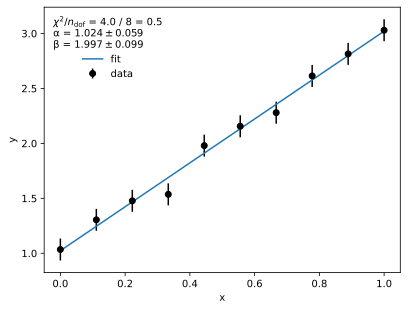

In [4]:
 # draw data and fitted line
plt.errorbar(data_x, data_y, data_yerr, fmt="ok", label="data")
plt.plot(data_x, line(data_x, *m.values), label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info), frameon=False)
plt.xlabel("x")
plt.ylabel("y")

In [5]:
m.interactive()

# 2D $\chi^2$ Example from https://github.com/scikit-hep/iminuit/blob/v2.30.2/doc/notebooks/cost_functions.ipynb

# Simple $\chi^2$ Fit with Spherical Harmonics

In [2]:
import OpenMpUtilities
OpenMpUtilities.enableRootACLiCOpenMp()
ROOT.gSystem.Load("/home/bgrube/.local/lib/python3.9/site-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so")
# OpenMpUtilities.printRootACLiCSettings()
ROOT.gROOT.LoadMacro("./basisFunctions.C+")

Enabling ACLiC compilation with OpenMP for Linux


0

In [3]:
thetaFormula   = "x"
phiFormula     = "y"
intensityTerms = []
for (L, M), parName in (((0, 0), "H000"), ((1, 0), "H010"), ((1, 1), "H011")):
  intensityTerms.append(
    f"{np.sqrt((2 * L + 1) / (4 * math.pi)) * (1 if M == 0 else 2)} "
    f"* [{parName}] * ReYlm({L}, {M}, {thetaFormula}, {phiFormula})"
  )
intensityFormula = " + ".join(intensityTerms)
print(f"{intensityFormula=}")

intensityFormula='0.28209479177387814 * [H000] * ReYlm(0, 0, x, y) + 0.4886025119029199 * [H010] * ReYlm(1, 0, x, y) + 0.9772050238058398 * [H011] * ReYlm(1, 1, x, y)'


Warning in <THistPainter::PaintSurface>: too many color levels, 100, reset to 8


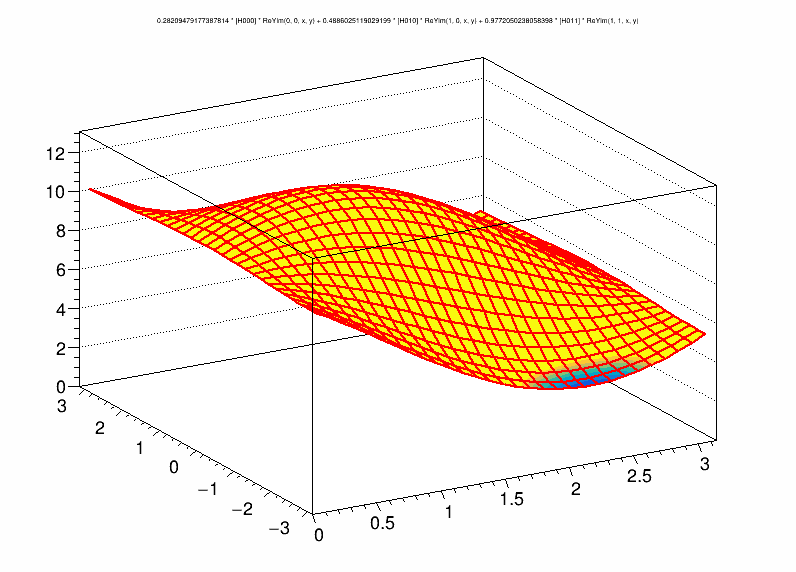

In [4]:
# modelFunc = ROOT.TF2("modelFunc", f"{intensityFormula};#theta [rad]; #phi [rad]", 0, math.pi, -math.pi, +math.pi)
modelFunc = ROOT.TF2("modelFunc", intensityFormula, 0, math.pi, -math.pi, +math.pi)
modelFunc.SetParameter("H000", 100)
modelFunc.SetParameter("H010",  10)
modelFunc.SetParameter("H011", -10)
canv = ROOT.TCanvas("canv", "", 800, 600)
modelFunc.Draw("surf1")
canv.Draw()

list(zip(thetaCoords, phiCoords))=[(0.0, -3.141592653589793), (0.7853981633974483, -3.141592653589793), (1.5707963267948966, -3.141592653589793), (2.356194490192345, -3.141592653589793), (3.141592653589793, -3.141592653589793), (0.0, -1.5707963267948966), (0.7853981633974483, -1.5707963267948966), (1.5707963267948966, -1.5707963267948966), (2.356194490192345, -1.5707963267948966), (3.141592653589793, -1.5707963267948966), (0.0, 0.0), (0.7853981633974483, 0.0), (1.5707963267948966, 0.0), (2.356194490192345, 0.0), (3.141592653589793, 0.0), (0.0, 1.5707963267948966), (0.7853981633974483, 1.5707963267948966), (1.5707963267948966, 1.5707963267948966), (2.356194490192345, 1.5707963267948966), (3.141592653589793, 1.5707963267948966), (0.0, 3.141592653589793), (0.7853981633974483, 3.141592653589793), (1.5707963267948966, 3.141592653589793), (2.356194490192345, 3.141592653589793), (3.141592653589793, 3.141592653589793)]
funcVals=array([10.3450713 ,  7.2585161 ,  4.58156097,  3.88232992,  5.5704

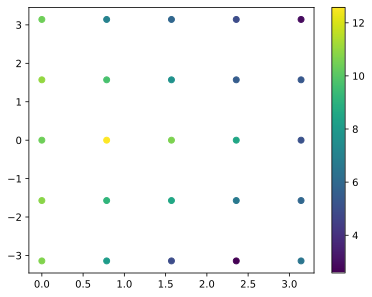

In [29]:
# see 2D least-squares example in https://github.com/scikit-hep/iminuit/blob/v2.30.2/doc/notebooks/cost_functions.ipynb
nmbPoints = 5
rng = np.random.default_rng(1)
thetaVals = np.linspace(0,         math.pi, nmbPoints, dtype = np.double)
phiVals   = np.linspace(-math.pi, +math.pi, nmbPoints, dtype = np.double)
grid = np.meshgrid(thetaVals, phiVals)
thetaCoords = grid[0].flatten()
phiCoords   = grid[1].flatten()
dataUncert = 1.0
funcVals = np.array([modelFunc.Eval(theta, phi) for theta, phi in zip(thetaCoords, phiCoords)], np.double)
dataVals = rng.normal(funcVals, dataUncert)
print(f"{list(zip(thetaCoords, phiCoords))=}\n{funcVals=}\n{dataVals=}")
plt.scatter(thetaCoords, phiCoords, c = dataVals)
plt.colorbar()

In [30]:
ROOT.gInterpreter.ProcessLine(f'TFormula modelFunc = TFormula("modelFunc", "{intensityFormula}");')

ROOT.gInterpreter.ProcessLine(
"""
std::vector<double>
modelFuncVec(
  const std::vector<double>& thetaVals,
  const std::vector<double>& phiVals,
  const std::vector<double>& parValues
) {
  const size_t nmbEvents = thetaVals.size();
  assert(phiVals.size() == nmbEvents);
  auto funcVals = std::vector<double>(nmbEvents);
	// multi-threaded loop over events using OpenMP
	#pragma omp parallel for
  for (size_t i = 0; i < nmbEvents; ++i) {
    const double varValues[2] = {thetaVals[i], phiVals[i]};
    funcVals[i] = modelFunc.EvalPar(varValues, parValues.data());
  }
  return funcVals;
}
"""
)

def modelFuncVec(dataCoords, parValues):
  thetaVals, phiVals = dataCoords
  # print(f"{thetaVals=}, {phiVals=}, {parValues=}")
  return np.array(ROOT.modelFuncVec(
    np.ascontiguousarray(thetaVals),
    np.ascontiguousarray(phiVals),
    parValues,
  ))

x = np.array([0, 1, 2], np.double)
y = np.array([0.5, 1.5, 2.5], np.double)
p = np.array([100, 10, -10], np.double)
print(f"{modelFuncVec(dataCoords = (x, y), parValues = p)=}")
for theta, phi in zip(x, y):
  print(f"{modelFunc.Eval(theta, phi)=}")

modelFuncVec(dataCoords = (x, y), parValues = p)=array([10.3450713 ,  9.44858565,  4.50479298])
modelFunc.Eval(theta, phi)=10.345071300973196
modelFunc.Eval(theta, phi)=9.448585648202496
modelFunc.Eval(theta, phi)=4.504792983410584


In [31]:
leastSquaresFunc = LeastSquares((thetaCoords, phiCoords), dataVals, dataUncert, modelFuncVec)
M = Minuit(leastSquaresFunc, (100, 0, 0), name = ("H000", "H010", "H011"))
M.migrad()  # finds minimum of leastSquaresFunc
M.hesse()  # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.44 (χ²/ndof = 0.7)      │              Nfcn = 67               │
│ EDM = 8.14e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ H000 │   99.6    │    2.6    │            │            │         │         │       │
│ 1 │ H010 │   11.3    │    1.1    │            │            │         │         │       │
│ 2 │ H011 │   -8.8    │    1.2    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬────────────────┐
│      │ H000 H010 H011 │
├──────┼────────────────┤
│ H000 │ 6.57  0.0 -0.6 │
│ H010 │  0.0 1.17 -0.0 │
│ H011 │ -0.6 -0.0 1.52 │
└──────┴────────────────┘

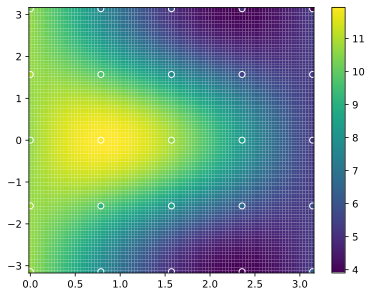

In [32]:
xm = np.linspace(0,         math.pi, 100)
ym = np.linspace(-math.pi, +math.pi, 100)
Xm, Ym = np.meshgrid(xm, ym)
xm = Xm.flatten()
ym = Ym.flatten()

qm = plt.pcolormesh(Xm, Ym, modelFuncVec((xm, ym), M.values).reshape(Xm.shape))
plt.scatter(leastSquaresFunc.x[0], leastSquaresFunc.x[1], c = leastSquaresFunc.y, edgecolors="w", norm = qm.norm)
plt.colorbar()

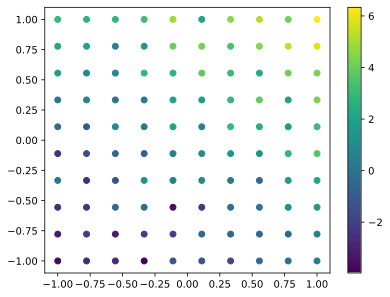

In [ ]:
def model2(x_y, a, bx, by):
    x, y = x_y
    return a + bx * x + by * y


# generate a regular grid in x and y
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
X, Y = np.meshgrid(x, y)
x = X.flatten()
y = Y.flatten()

# model truth
Z = model2((x, y), 1, 2, 3)

# add some noise
rng = np.random.default_rng(1)
Zerr = 1
Z = rng.normal(Z, Zerr)

plt.scatter(x, y, c=Z)
plt.colorbar()

In [24]:
c2 = LeastSquares((x, y), Z, Zerr, model2)
m2 = Minuit(c2, 0, 0, 0)
m2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 71.61 (χ²/ndof = 0.7)      │              Nfcn = 34               │
│ EDM = 5.66e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.93    │   0.10    │            │            │         │         │       │
│ 1 │ bx   │   1.87    │   0.16    │            │            │         │         │       │
│ 2 │ by   │   2.93    │   0.16    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────┐
│    │      a     bx     by │
├────┼──────────────────────┤
│  a │   0.01  0.000  0.000 │
│ bx │  0.000 0.0245  0.000 │
│ by │  0.000  0.000 0.0245 │
└────┴──────────────────────┘

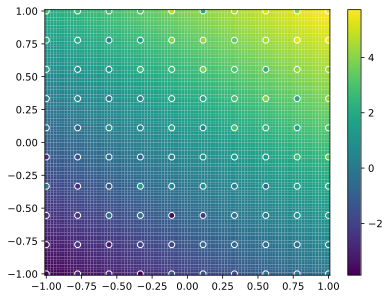

In [25]:
xm = np.linspace(-1, 1, 100)
ym = np.linspace(-1, 1, 100)
Xm, Ym = np.meshgrid(xm, ym)
xm = Xm.flatten()
ym = Ym.flatten()

qm = plt.pcolormesh(Xm, Ym, model2((xm, ym), *m2.values).reshape(Xm.shape))
plt.scatter(c2.x[0], c2.x[1], c=c2.y, edgecolors="w", norm=qm.norm)
plt.colorbar()